In [1]:
# Modif target_binary, ignore_column for next participant ????????????????????????????
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT'
trial_info_file = '/A0_kabir/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/A0_kabir/Experimental/data.mat'
epoch_file = '/my_code/epochs_from_matrix/epochs_0.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']
electrodes_kabir = ['POz', 'PO3', 'PO4', 'Pz', 'P1', 'P3', 'Oz', 'O1', 'O2']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt


In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']


In [4]:
# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0])+1, 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) 
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_54471/1908016345.py:18: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [5]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


In [6]:
# Keep only trials where there was no target
epochs = epochs['target_binary==0']

# A. Frequency tagging condition
# 1 - Tag presence
## 1.1 FFT & SNR

In [7]:
epochs_freqtag = epochs['tagging_type==0'].copy()

In [8]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0
sfreq = epochs_freqtag.info["sfreq"]

# Spectrum of the signal averaged over trials
spectrum = epochs_freqtag.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999)) (?? voir tuto pour explications, on ignore les bandes les plus proches car la fenetre target est tres etroite ?)

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get SNR on all frequency ranges, excluding close neighbors (±2Hz) from regularizing points (ask how many nei in original paper??
bin_size = np.diff(freqs)[0]
skip_nei = int((2 - bin_size/2)//bin_size)

snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)


/tmp/ipykernel_54471/4095154011.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


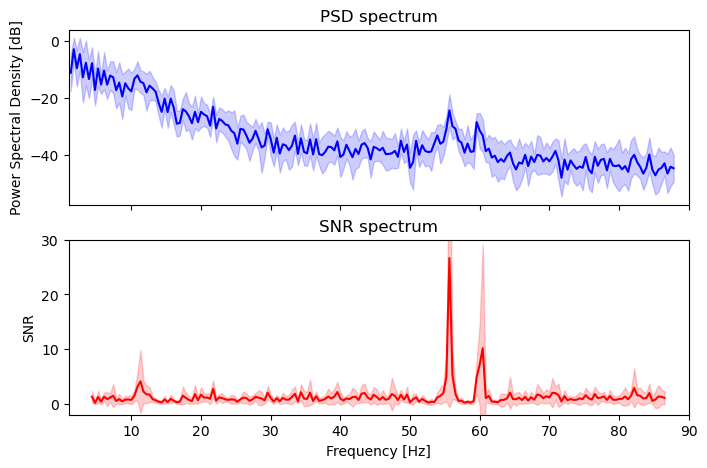

In [9]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

In [10]:
# Extract SNR values at the stimulation frequency --- ??? a corriger + ?en fun du cued
stim_freq1 = 55.5
stim_freq2 = 60

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs - stim_freq1))
i_bin_2 = np.argmin(abs(freqs - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


SNR at 55.5Hz: 26.641490773859974
SNR at 60Hz: 7.185293748601227


In [11]:
# Simplify metadata
epochs_freqtag.metadata['flicker_sides'] = epochs_freqtag.metadata['flicker_sides'].replace({0: 6056, 1: 5660})
epochs_freqtag.metadata['cued_side'] = epochs_freqtag.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'left')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'right')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'left'))
epochs_freqtag.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 56, np.nan))

## 1.2 Topography of the SNR

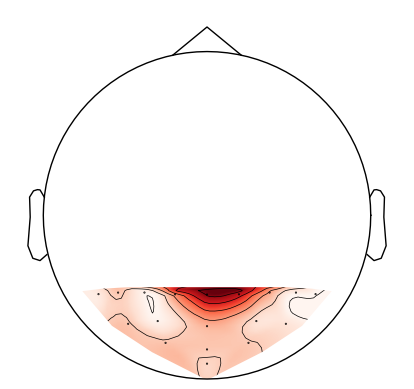

/tmp/ipykernel_54471/2059831999.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


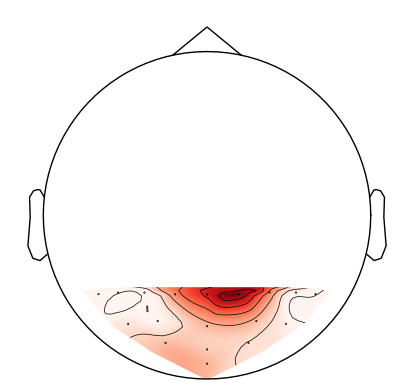

/tmp/ipykernel_54471/2059831999.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

In [13]:
# Channels with the highest SNR 
print(f'Channels with highest SNR for 56Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]}')
print(f'Channels with highest SNR for 60Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:4]}')

Channels with highest SNR for 56Hz['Pz' 'P2' 'P1' 'P4']
Channels with highest SNR for 60Hz['P2' 'Pz' 'P4' 'P1']


In [14]:
SNR_best_electrodes = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:4]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [15]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

### Coherence with Hilbert transform

In [16]:
def coherence_kabir(signalX, pick, freq_of_interest):

    #get info from EEG
    min_time = signalX.times[0]
    max_time = signalX.times[-1]
    sampling_rate = signalX.info['sfreq']
    
    # Band-pass EEG (+/-1.9Hz) and apply hilbert
    signalXh = signalX.copy().pick(pick).filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=False).apply_hilbert()
    signalXh = np.squeeze(signalXh.get_data(copy=False)).T
    n = signalXh.shape[1]  # number of trials

    #Create sine wave
    t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
    signalY = np.sin(2 * np.pi * freq_of_interest * t)
    signalY = np.tile(signalY, (n,1)).T #repeat over trials
    # Hilbert transform
    signalYh = scipy.signal.hilbert(signalY.T, axis=1)

    # Magnitude
    mX = np.abs(signalXh).T
    mY = np.abs(signalYh)

    # Phase difference
    phase_diff = np.angle(signalXh).T - np.angle(signalYh)

    coh = np.zeros(signalY.shape[0])
    for t in range(signalY.shape[0]):
        num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
        denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
        coh[t] = num/denom
        
    return coh

channels = epochs_freqtag.info['ch_names']

epochs_freqtag_cropped = epochs_freqtag.copy().crop(tmin, tmax)

coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_freqtag_cropped.times)))

for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_freqtag_cropped, [channel], freq)

coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_freqtag_cropped.info, np.array([coherence_mat]), epochs_freqtag_cropped.times, freqs)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


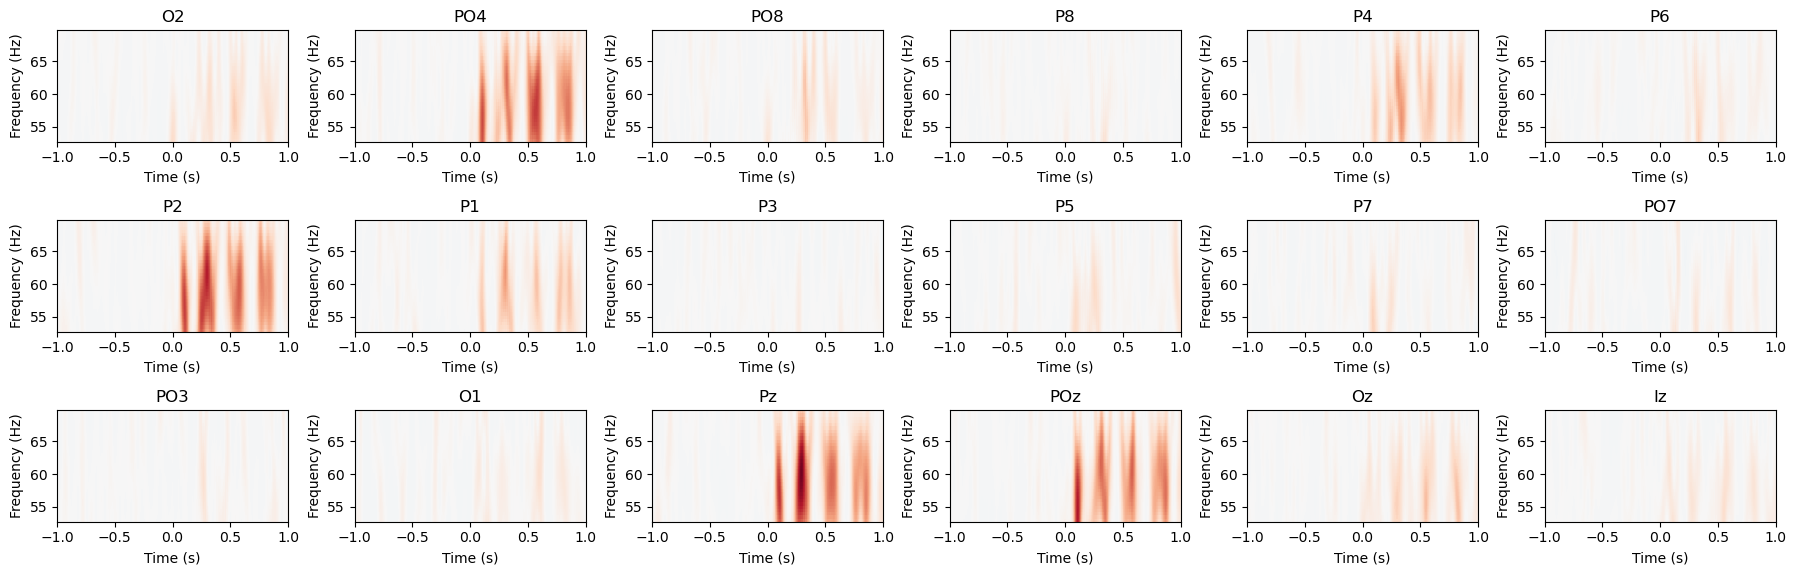

In [17]:
fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
axes = axes.flatten() 

# Plot each channel
for e, (channel, ax) in enumerate(zip(channels, axes)):
    coherence_hilbert.plot(
        [e],
        baseline=(tmin, 0),
        mode="mean",
        vlim=(-.3, .3),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel)  

plt.tight_layout()
plt.show()

### Coherence with Morlet estimation across all no target trials

In [18]:
# Get inter-trial coherence (from a Morlet time-frequency estimation)
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

_, itc = epochs_freqtag.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs, return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc = itc.apply_baseline(baseline=(tmin, 0))

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.2s


Applying baseline correction (mode: mean)


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


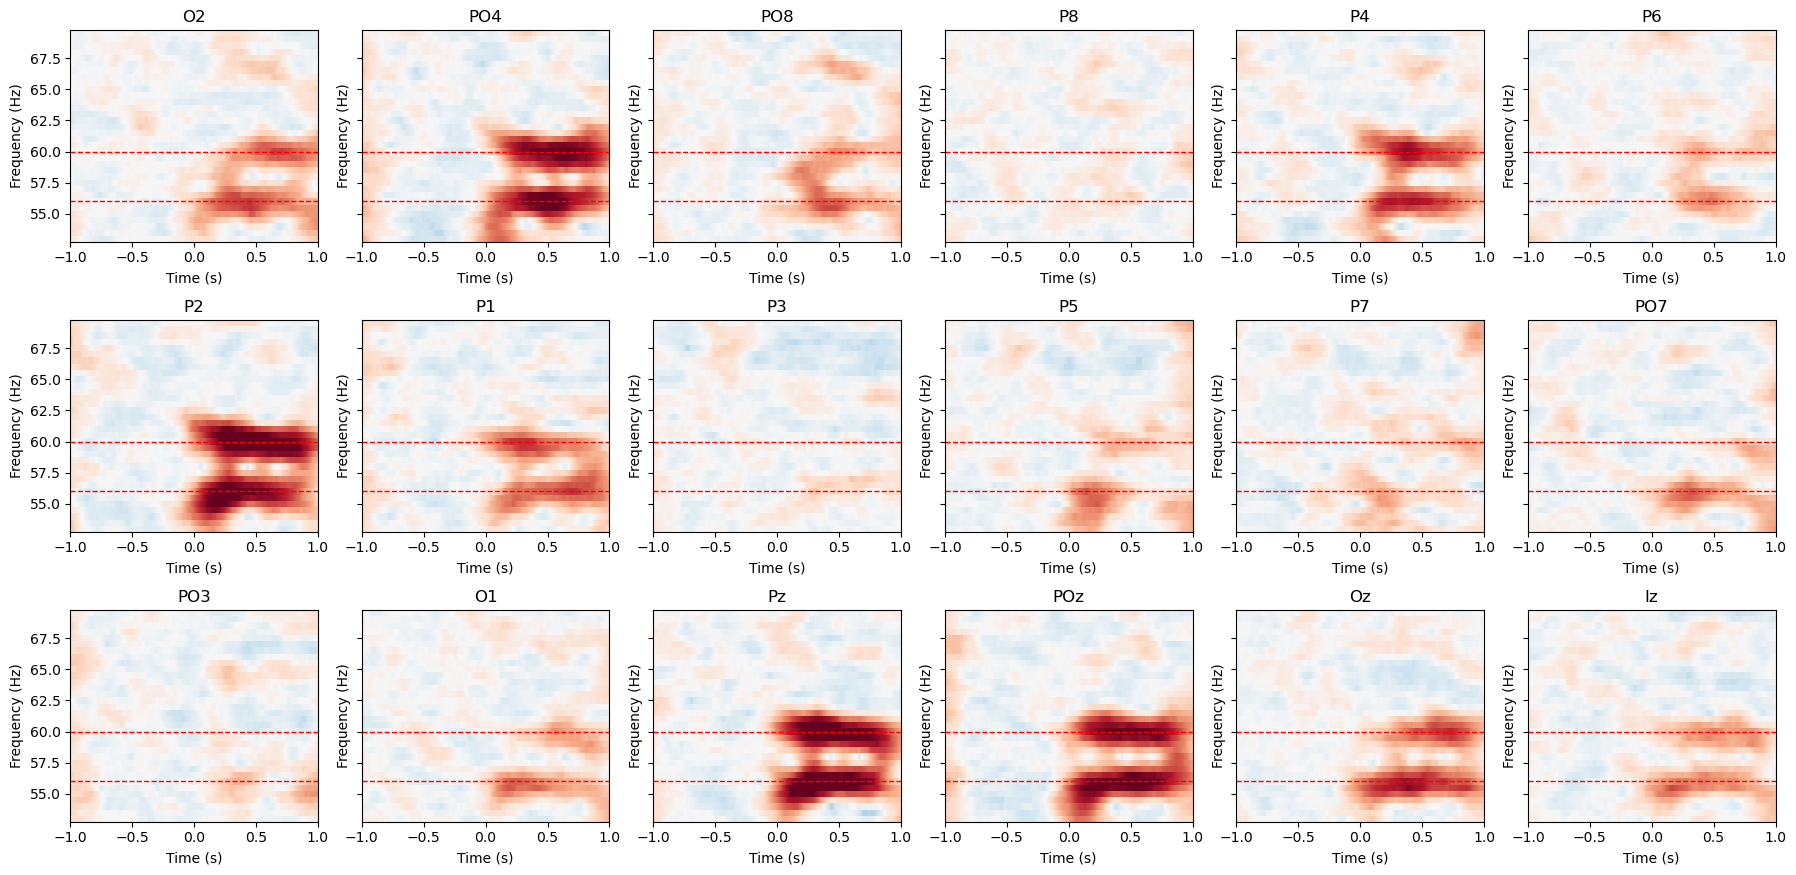

In [19]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

# Plot each electrode
for e, (elec, ax) in enumerate(zip(epochs_freqtag.info['ch_names'], axes)):
    itc.plot(
        picks=[elec],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(elec) 
    ax.axhline(y=56, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [20]:
# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc.get_data(return_freqs=True)
print(f'Frequencies with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')

Frequencies with the maximum coherence in descending order : [56.  55.5 60.  56.5]


### Select electrodes based on coherence (across trials of a same cued frequency)

In [21]:
# Get inter-trial coherence with 56 and 60Hz by cued frequency 
freqs = [56, 60]
_, itc_60 = epochs_freqtag['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=np.array(freqs)/2, return_itc=True, average=True
)
# Baseline (-1 to 0s) correction
itc_60 = itc_60.apply_baseline(baseline=(-1, 0 ))

_, itc_56 = epochs_freqtag['cued_tag == 56'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=np.array(freqs)/2, return_itc=True, average=True
)
# Baseline (-1 to 0s) correction
itc_56 = itc_56.apply_baseline(baseline=(-1, 0 ))

itc_60_arr, times, freqs_idx = itc_60.get_data(return_freqs = True, return_times = True)
itc_56_arr = itc_56.get_data()
freqs_idx

Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


array([56., 60.])

In [22]:
# Channels with the highest coherence with the cued frequency
print(f'From best to 4th \nChannels with the highest coherence with 60 when 60 was cued:{np.array(epochs.info['ch_names'])[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1]][:4]} \
                        \nChannels with the highest coherence with 56 when 56 was cued:{np.array(epochs.info['ch_names'])[np.argsort(itc_56_arr[:,0,:].max(axis = 1))[::-1]][:4]}')

From best to 4th 
Channels with the highest coherence with 60 when 60 was cued:['P2' 'PO4' 'Pz' 'POz']                         
Channels with the highest coherence with 56 when 56 was cued:['Pz' 'PO4' 'P2' 'POz']


In [23]:
best_electrodes_coherence = np.array(epochs.info['ch_names'])[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1]][:4]

# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

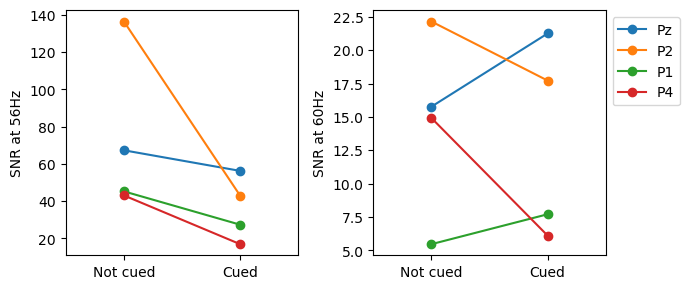

In [24]:
queries = ["cued_tag == 60", "cued_tag == 56"]
vals = {}
stim_freq1 = 55.5
stim_freq2 = 60.5

tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick(SNR_best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="boxcar",
        verbose=False,
    )
    psds, freqs = spectrum.get_data(return_freqs=True)
    bin_size = np.diff(freqs)[0]
    skip_nei = int((2 - bin_size/2)//bin_size)
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=2, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs - stim_freq2))
    
    # Apply the subset
    vals[query] = snrs[:, [i_bin_1,i_bin_2]]

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(SNR_best_electrodes):
    ax[0].plot([0,1], [vals['cued_tag == 60'][e,0], vals['cued_tag == 56'][e,0]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['cued_tag == 60'][e,1], vals['cued_tag == 56'][e,1]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

### Comparing Morlet coherence across cued conditions

In [25]:
coherence_with60_for60cued_top4ch = itc_60_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],1,:]
coherence_with60_for56cued_top4ch = itc_60_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],0,:]
coherence_with56_for60cued_top4ch = itc_56_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],1,:]
coherence_with56_for56cued_top4ch = itc_56_arr[np.argsort(itc_60_arr[:,1,:].max(axis = 1))[::-1][:4],0,:]

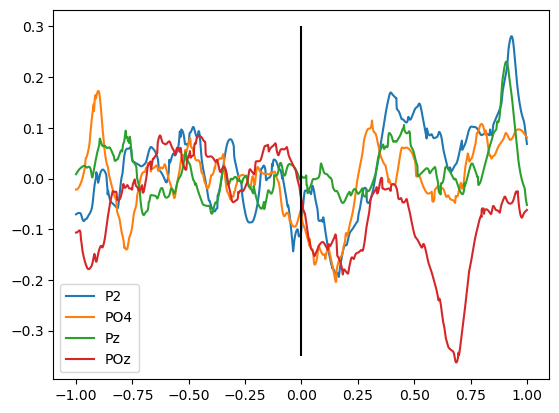

In [26]:
plt.plot(times, coherence_with60_for60cued_top4ch.T - coherence_with60_for56cued_top4ch.T, label = best_electrodes_coherence)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()

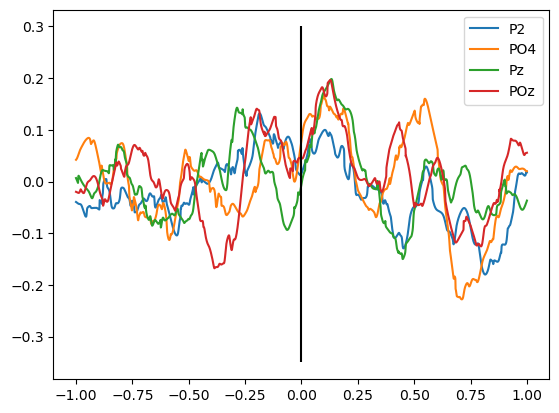

In [27]:
plt.plot(times, coherence_with56_for56cued_top4ch.T - coherence_with56_for60cued_top4ch.T, label = best_electrodes_coherence)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()